# Marxianos Siefore Básica Inicial S.A. de C.V.
Análisis, notas técnicas y programación financiera para la toma de decisiones

## Supuestos
- Total Return como información histórica para análisis de desempeño instrumento-benchmark
- 70% de la inversión en Renta Variable debe de estar encontrarse como mínimo, en el 70% de las mejores ESG scores en el mercado
- 5 Empresas con mayor market cap Mexicanas
- 5 Empresas internacionales con mayor market cap y mayor al percentil 70 en ESG

## Restricciones
Estos son los límites de la CONSAR para los portafolios de la Siefore Básica Inicial.

|Activo|Monto máximo|
|------|------------|
|Deuda Fedaral/Baxico|100|
|FIBRAs|10|
|Renta Variable|60|
|Valores Internacionales|20|

In [ ]:
import refinitiv.data as rd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import translators as ts

In [85]:
# Variables de interes
start_date = "2019-01-01"
# Fecha de hace dos días (fecha máxima en la que la extracción de datos no supone un problema)
end_date = (datetime.today() - timedelta(days=2)).strftime("%Y-%m-%d")
color_titulo = "#4ba173"
color_subtitulo = "#63d297"
color_cuerpo = "#616161"

fields_etfs = [
    "TR.InstrumentDescription", # Nombre del instrumento
    "TR.FundObjective", # Objetivo del Fondo
    "TR.ExchangeCountry", # País de origen
    "TR.FundBenchmarkName", # Nombre del Benchmark
    "TR.FundBenchmarkInstrumentRIC", # Simbolo del Benchmark principal
    ]
fields_acciones = [
    "TR.InstrumentDescription", # Nombre del instrumento
    "TR.ExchangeCountry" # País de origen
    ]
indice_esg = ".SPGESUT" # Rendimiento Total de S&P ESG index

In [86]:
# Funciones de interes
def traduce_es(texto):
    """Función que traduce texto de español a ingles

    ## Parametros
    texto: str-like
        El texto por traducir
    """
    try:
        texto_es = ts.google(texto, from_language="en", to_language="es")
    except:
        texto_es = "No es posible traducir el texto."
    return texto_es


def instrumentos_TR(instrumentos, fields="TR.TotalReturn", start_date=start_date, end_date=end_date, drop_level=True):
    """
    Obtiene el Total Return (Cambios en el precio + Dividendos) de los instrumentos, dada una fecha
    de inicio y fecha de fin.
    
    Resultados de Refinitiv.

    # Argumentos
    instrumentos: list-like
        Una lista con los símbolos (RIC) de los instrumentos.
        e.g. ["INSTRUMENTO1.MX", "INSTRUMENTO2.MX"]
    start_date: str-like
        Un string con la fecha de inicio para la busqueda de resultados. Del tipo YYYY-MM-DD
        e.g. "2022-01-01"
    end_date: str-like
        Un string con la fecha de termino para la busqueda de resultados. Del tipo YYYY-MM-DD
        e.g. "2022-01-01"
    drop_level: bool-like
        Indica si se quiere eliminar el multinivel en las columnas, para que solo aparezca la emisora
    """
    # Genera el dataframe de tipo timeseries de los instrumentos con los parametros
    try:
        instrumentos_tr = (rd.get_history(
            universe=instrumentos,
            fields=fields, # Cambios en el precio + Dividendos
            interval="daily", # Resultados diarios
            start=start_date,
            end=end_date)
            .sort_index(ascending=True) # Regresa los resultados con fecha ascendente
            .astype("str")
            .replace({"<NA>":np.nan})
            .astype("float64")
            .fillna(method="pad") # Rellena los valores vacios con el último valor observado
            .drop_duplicates()
            .loc[start_date:end_date]
            )
        
        if drop_level:
            # Quita el nivel de subcolumna "Total Return"
            instrumentos_tr = instrumentos_tr.droplevel(1, axis="columns")
        # Regresa el dataframe sobre 100 para obtener los valores de crecimiento en decimales
        return (instrumentos_tr / 100)

    except Exception as e:
        # Si se encuentra un error, imprimelo y regresa un False
        print("[ERROR!]: {}".format(e))
        return False

In [87]:
# Data de interes
# Informacion de los instrumentos del portafolio
instrumentos = {
    # Economías Indexadas
    "IVV": { # Estados Unidos
        "Tipo": "Renta Variable",
        "Categoría" : "ETF",
        "Subcategoría": "Economía Indexada"
        },
    "MCHI.O": { # China
        "Tipo": "Renta Variable",
        "Categoría": "ETF",
        "Subcategoría": "Economía Indexada"
        },
    "EWJ": { # Japón
        "Tipo": "Renta Variable",
        "Categoría": "ETF",
        "Subcategoría": "Economía Indexada"
        },
    "EWU": { # Reindo Unido
        "Tipo": "Renta Variable",
        "Categoría": "ETF",
        "Subcategoría": "Economía Indexada"
        },
    "NAFTRACISHRS.MX": { # México
        "Tipo": "Renta Variable",
        "Categoría": "ETF",
        "Subcategoría": "Economía Indexada"
        },
    # Sectores Indexados
    "XLK": {
        "Tipo": "Renta Variable",
        "Categoría": "ETF",
        "Subcategoría": "Sector Indexado"
        },
    "VNQI.O": {
        "Tipo": "Renta Variable",
        "Categoría": "ETF",
        "Subcategoría": "Sector Indexado"
        },
    #"IYR": {
    #    "Tipo": "Renta Variable",
    #    "Categoría": "ETF",
    #    "Subcategoría": "Sector Indexado"
    #    },
    "XLY": {
        "Tipo": "Renta Variable",
        "Categoría": "ETF",
        "Subcategoría": "Sector Indexado"
        },
    # Safe heaven ETFs / Others
    # Commodity de oro
    "GLD": {
        "Tipo": "Renta Variable",
        "Categoría": "ETF",
        "Subcategoría": "Otros"
        },
    # ETF de deuda corporativa
    "CORPTRCISHRS.MX": {
        "Tipo": "Renta Variable",
        "Categoría": "ETF",
        "Subcategoría": "Otros"
        },
    # FIBRAs
    "EDUCA18.MX": {
        "Tipo": "Renta Variable",
        "Categoría": "Acción",
        "Subcategoría": "FIBRA"
        },
    "FMTY14.MX": {
        "Tipo": "Renta Variable",
        "Categoría": "Acción",
        "Subcategoría": "FIBRA"
        },
    "DANHOS13.MX": {
        "Tipo": "Renta Variable",
        "Categoría": "Acción",
        "Subcategoría": "FIBRA",
        },
    "FNOVA17.MX": {
        "Tipo": "Renta Variable",
        "Categoría": "Acción",
        "Subcategoría": "FIBRA"
        },
    # Acciones nacionales
    "ALPEKA.MX": {
        "Tipo": "Renta Variable",
        "Categoría": "Acción",
        "Subcategoría": "Nacional"
        },
    "AC.MX": {
        "Tipo": "Renta Variable",
        "Categoría": "Acción",
        "Subcategoría": "Nacional"
        },
    "ASURB.MX": {
        "Tipo": "Renta Variable",
        "Categoría": "Acción",
        "Subcategoría": "Nacional"
        },
    "KOFUBL.MX": {
        "Tipo": "Renta Variable",
        "Categoría": "Acción",
        "Subcategoría": "Nacional"
        },
    "WALMEX.MX": {
        "Tipo": "Renta Variable",
        "Categoría": "Acción",
        "Subcategoría": "Nacional"
        },
    # Acciones internacionales
    "AAPL.OQ": {
        "Tipo": "Renta Variable",
        "Categoría": "Acción",
        "Subcategoría": "Internacional",
        },
    "MSFT.OQ": {
        "Tipo": "Renta Variable",
        "Categoría": "Acción",
        "Subcategoría": "Internacional"
        },
    "DGE.L": {
        "Tipo": "Renta Variable",
        "Categoría": "Acción",
        "Subcategoría": "Internacional"
        },
    "RKT.L": {
        "Tipo": "Renta Variable",
        "Categoría": "Acción",
        "Subcategoría": "Internacional"
        },
    "MNST.OQ": {
        "Tipo": "Renta Variable",
        "Categoría": "Acción",
        "Subcategoría": "Internacional"
        },
    
    }

# Imprime el dataframe con los instrumentos del portafolio
instrumentos_df = pd.DataFrame(instrumentos).T
# Presenta el dataframe de instrumentos
instrumentos_df

,Tipo,Categoría,Subcategoría
IVV,Renta Variable,ETF,Economía Indexada
MCHI.O,Renta Variable,ETF,Economía Indexada
EWJ,Renta Variable,ETF,Economía Indexada
EWU,Renta Variable,ETF,Economía Indexada
NAFTRACISHRS.MX,Renta Variable,ETF,Economía Indexada
XLK,Renta Variable,ETF,Sector Indexado
VNQI.O,Renta Variable,ETF,Sector Indexado
XLY,Renta Variable,ETF,Sector Indexado
GLD,Renta Variable,ETF,Otros
CORPTRCISHRS.MX,Renta Variable,ETF,Otros


In [88]:
etfs_all = rd.get_data(
    universe=instrumentos_df[instrumentos_df["Categoría"] == "ETF"].index.to_list(),
    fields=fields_etfs
).rename(columns={"Benchmark Instrument RIC": "Benchmark RIC", "Benchmark Name": "Nombre Benchmark"})
etfs_all

,Instrument,Instrument Description,Objective,Country of Exchange,Nombre Benchmark,Benchmark RIC
0,IVV,iShares Core S&P 500 ETF,The Fund seeks investment results that corresp...,United States of America,S&P 500 TR,.SPXTR
1,MCHI.O,iShares MSCI China ETF,The Fund seeks to track the investment results...,United States of America,MSCI China NR USD,.dMICN00000NUS
2,EWJ,iShares MSCI Japan ETF,The Fund seeks to track the investment results...,United States of America,MSCI Japan NR USD,.dMIJP00000NUS
3,EWU,iShares MSCI United Kingdom ETF,The Fund seeks to track the investment results...,United States of America,MSCI United Kingdom NR USD,.dMIGB00000NUS
4,NAFTRACISHRS.MX,iShares NAFTRAC,The Fund aims to search for investment results...,Mexico,S&P/BMV IPC,.MXX
5,XLK,Technology Select Sector SPDR Fund,The Fund seeks to provide investment results t...,United States of America,Technology Select Sector TR,.IXTTR
6,VNQI.O,Vanguard Global ex-US Real Estate Index Fd;ETF,The Fund seeks to track the performance of a b...,United States of America,S&P Global Ex-U.S. Property TR,<NA>
7,XLY,Consumer Discretionary Select Sector SPDR Fund,The Fund seeks to provide investment results t...,United States of America,Consumer Discretionary Select Sector TR,.IXYTR
8,GLD,SPDR Gold Shares,The Fund seeks to achieve the performance of g...,United States of America,Engelhard Gold Index,.GLDD
9,CORPTRCISHRS.MX,iShares Mexico Corporate Bond TRAC,The Fund seeks investment results that general...,Mexico,S&P/BMV CORPOTRAC TR MXN,.SPVCORT


In [71]:
udibonos = rd.get_history(
    universe=["MX251204UD=RRPS", "WALMEX.MX"],
    fields="TR.DAILYTOTALRETURN",
    start=start_date,
    end=end_date
)
udibonos

,MX251204UD=RRPS,WALMEX.MX
,Daily Total Return,Daily Total Return
Date,,
2022-06-09 00:00:00+00:00,0.1293,NaN
2022-06-08 00:00:00+00:00,0.7606,NaN
2022-06-07 00:00:00+00:00,-2.0616,NaN
2022-06-06 00:00:00+00:00,-0.1157,NaN
2022-06-03 00:00:00+00:00,-0.1159,NaN
...,...,...
2019-01-07 00:00:00+00:00,-0.1907,NaN
2019-01-04 00:00:00+00:00,-0.2463,NaN


In [96]:
all = instrumentos_TR(instrumentos_df.index.to_list(), end_date="2022-06-10")
all

,IVV,MCHI.O,EWJ,EWU,NAFTRACISHRS.MX,XLK,VNQI.O,XLY,GLD,CORPTRCISHRS.MX,...,ALPEKA.MX,AC.MX,ASURB.MX,KOFUBL.MX,WALMEX.MX,AAPL.OQ,MSFT.OQ,DGE.L,RKT.L,MNST.OQ
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02 00:00:00+00:00,0.000437,-0.005511,0.006905,-0.000681,0.016121,0.000645,-0.007060,0.007575,0.000660,-0.024299,...,0.020374,-0.005739,0.033522,0.013848,-0.005003,0.001141,-0.004430,-0.012165,0.001663,-0.009346
2019-01-03 00:00:00+00:00,-0.024988,-0.025416,-0.005682,-0.006137,-0.004736,-0.050468,0.001537,-0.021652,0.009066,-0.024299,...,-0.007742,0.007055,-0.015189,0.011010,-0.019509,-0.099607,-0.036788,-0.007606,-0.009630,-0.015587
2019-01-04 00:00:00+00:00,0.035163,0.040588,0.033892,0.027787,0.008803,0.044320,0.021873,0.033094,-0.008086,0.000000,...,0.018480,0.006915,0.030945,0.006796,0.018667,0.042689,0.046509,0.000182,-0.000168,0.037292
2019-01-07 00:00:00+00:00,0.006731,0.009610,0.002478,0.000000,0.009434,0.008943,0.005821,0.022612,0.003458,0.026449,...,0.037097,0.007409,0.022006,0.007563,0.003625,-0.002226,0.001275,-0.007845,-0.006539,-0.001205
2019-01-08 00:00:00+00:00,0.009853,0.007652,0.004753,0.006008,0.017523,0.008380,0.007840,0.011056,-0.002708,0.026449,...,0.008554,0.009508,0.024082,0.008233,0.013644,0.019063,0.007251,0.005885,0.017722,0.062337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-06 00:00:00+00:00,0.003007,0.023695,0.005438,0.005779,-0.011746,0.000071,0.001262,0.010000,-0.004404,0.001267,...,0.011150,-0.022597,-0.007346,-0.012672,-0.026970,0.005228,-0.004703,0.022777,0.006796,0.028481
2022-06-07 00:00:00+00:00,0.009284,0.018065,0.003140,0.008467,0.001189,0.011929,-0.002732,-0.002459,0.006518,-0.012658,...,0.007224,0.012107,-0.005232,0.016155,-0.011116,0.017586,0.013953,-0.013227,-0.004500,-0.005582
2022-06-08 00:00:00+00:00,-0.010827,0.031793,-0.013043,-0.014093,-0.006727,-0.011294,-0.006953,-0.005903,-0.000925,0.000000,...,0.025293,-0.015820,-0.006586,-0.015457,0.012409,-0.005043,-0.007670,-0.015183,-0.010978,-0.006714


In [82]:
all_info = rd.get_data(
    universe=instrumentos_df.index.to_list(),
    fields=fields_acciones
)
all_info.columns = ["Instrumento", "Nombre", "País de intercambio"]
all_info

,Instrumento,Nombre,País de intercambio
0,IVV,iShares Core S&P 500 ETF,United States of America
1,MCHI.O,iShares MSCI China ETF,United States of America
2,EWJ,iShares MSCI Japan ETF,United States of America
3,EWU,iShares MSCI United Kingdom ETF,United States of America
4,NAFTRACISHRS.MX,iShares NAFTRAC,Mexico
5,XLK,Technology Select Sector SPDR Fund,United States of America
6,VNQI.O,Vanguard Global ex-US Real Estate Index Fd;ETF,United States of America
7,XLY,Consumer Discretionary Select Sector SPDR Fund,United States of America
8,GLD,SPDR Gold Shares,United States of America
9,CORPTRCISHRS.MX,iShares Mexico Corporate Bond TRAC,Mexico


In [89]:
all_info_ = instrumentos_df.join(all_info.set_index("Instrumento"))
all_info_ = all_info_.merge(
    etfs_all.set_index("Instrument")[["Nombre Benchmark", "Benchmark RIC"]],
     left_index=True, right_index=True, how="outer").loc[all_info["Instrumento"]]
# Indice de acciones nacionales ESG
all_info_["Benchmark RIC"].mask(all_info_["Subcategoría"] == "Nacional", ".UR0000", inplace=True) # S&P/BMV Total Mexico ESG Index (USD) TR
all_info_["Nombre Benchmark"].mask(all_info_["Subcategoría"] == "Nacional", "S&P/BMV Total Mexico ESG Index (USD) TR", inplace=True)
# Indice de acciones internacionales ESG
all_info_["Benchmark RIC"].mask(all_info_["Subcategoría"] == "FIBRA", ".FR", inplace=True) # S&P/BMV FIBRAS INDEX TR
all_info_["Nombre Benchmark"].mask(all_info_["Subcategoría"] == "FIBRA", "S&P/BMV FIBRAS Index TR", inplace=True)
# Global ESG Leaders
all_info_["Benchmark RIC"].mask(all_info_["Subcategoría"] == "Internacional", ".SXWESGP", inplace=True)
all_info_["Nombre Benchmark"].mask(all_info_["Subcategoría"] == "Internacional", "STOXX Global ESG Leaders (PR EUR) Index", inplace=True)
# VQI.O
all_info_["Benchmark RIC"].mask(all_info_["Nombre Benchmark"] == "S&P Global Ex-U.S. Property TR", ".SPBMGUU", inplace=True)
all_info_

,Tipo,Categoría,Subcategoría,Nombre,País de intercambio,Nombre Benchmark,Benchmark RIC
IVV,Renta Variable,ETF,Economía Indexada,iShares Core S&P 500 ETF,United States of America,S&P 500 TR,.SPXTR
MCHI.O,Renta Variable,ETF,Economía Indexada,iShares MSCI China ETF,United States of America,MSCI China NR USD,.dMICN00000NUS
EWJ,Renta Variable,ETF,Economía Indexada,iShares MSCI Japan ETF,United States of America,MSCI Japan NR USD,.dMIJP00000NUS
EWU,Renta Variable,ETF,Economía Indexada,iShares MSCI United Kingdom ETF,United States of America,MSCI United Kingdom NR USD,.dMIGB00000NUS
NAFTRACISHRS.MX,Renta Variable,ETF,Economía Indexada,iShares NAFTRAC,Mexico,S&P/BMV IPC,.MXX
XLK,Renta Variable,ETF,Sector Indexado,Technology Select Sector SPDR Fund,United States of America,Technology Select Sector TR,.IXTTR
VNQI.O,Renta Variable,ETF,Sector Indexado,Vanguard Global ex-US Real Estate Index Fd;ETF,United States of America,S&P Global Ex-U.S. Property TR,.SPBMGUU
XLY,Renta Variable,ETF,Sector Indexado,Consumer Discretionary Select Sector SPDR Fund,United States of America,Consumer Discretionary Select Sector TR,.IXYTR
GLD,Renta Variable,ETF,Otros,SPDR Gold Shares,United States of America,Engelhard Gold Index,.GLDD
CORPTRCISHRS.MX,Renta Variable,ETF,Otros,iShares Mexico Corporate Bond TRAC,Mexico,S&P/BMV CORPOTRAC TR MXN,.SPVCORT


In [90]:
indices_ = list(all_info_["Benchmark RIC"].unique())
indices_.remove(".SPVCORT")
indices_.remove(".SPBMGUU")
indices_

['.SPXTR',
 '.dMICN00000NUS',
 '.dMIJP00000NUS',
 '.dMIGB00000NUS',
 '.MXX',
 '.IXTTR',
 '.IXYTR',
 '.GLDD',
 '.FR',
 '.UR0000',
 '.SXWESGP']

In [91]:
indices_data = instrumentos_TR(indices_, fields="TR.PriceClose", end_date="2022-06-10")
# Llena los na con la mediana y multiplica
indices_data = indices_data.fillna(indices_data.median())
indices_data = indices_data.pct_change().dropna()
indices_data

,.SPXTR,.dMICN00000NUS,.dMIJP00000NUS,.dMIGB00000NUS,.MXX,.IXTTR,.IXYTR,.GLDD,.FR,.UR0000,.SXWESGP
Date,,,,,,,,,,,
2019-01-02 00:00:00+00:00,0.001272,-0.022427,0.003843,-0.009616,0.015150,0.000673,0.007704,0.003116,0.033212,0.023095,-0.000288
2019-01-03 00:00:00+00:00,-0.024498,-0.013647,0.016083,-0.005330,-0.005366,-0.050304,-0.021464,0.003114,0.012625,-0.004947,-0.007700
2019-01-04 00:00:00+00:00,0.034336,0.028375,-0.021053,0.030963,0.009771,0.043954,0.033423,-0.001548,0.004921,0.022219,0.022119
2019-01-07 00:00:00+00:00,0.007013,0.014269,0.025839,-0.000082,0.008929,0.008619,0.022499,0.003884,-0.000612,0.012697,0.004115
2019-01-08 00:00:00+00:00,0.009717,0.002925,0.002480,0.004224,0.016544,0.009029,0.010900,-0.007738,0.012088,0.012189,0.008903
...,...,...,...,...,...,...,...,...,...,...,...
2022-06-06 00:00:00+00:00,0.003145,0.030867,-0.001872,0.012759,-0.012400,0.000233,0.009658,-0.003226,-0.011490,-0.008841,0.008027
2022-06-07 00:00:00+00:00,0.009552,0.002462,-0.004692,0.001417,0.001571,0.012052,-0.002284,-0.004854,0.012548,0.007227,-0.001805
2022-06-08 00:00:00+00:00,-0.010757,0.035549,0.001362,-0.002970,-0.006380,-0.011306,-0.005694,0.004878,0.012678,0.004985,-0.007871


In [94]:
# Lista de renta fija
rf = ["MX1YT=RRPS", "MX3YT=RRPS", "MX5YT=RRPS"] 
renta_fija = instrumentos_TR(rf, fields="ASK", end_date="2022-06-10").pct_change().dropna()
renta_fija["MX1YT=RRPS"] = renta_fija["MX1YT=RRPS"] + 0.000353 # Rendimiento diario de CETES
renta_fija["MX3YT=RRPS"] = renta_fija["MX3YT=RRPS"] + 0.008618 # Rendimiento diario de UDIbonos
renta_fija["MX5YT=RRPS"] = renta_fija["MX5YT=RRPS"] + 0.000345 # Rendimiento diario de BonosM
renta_fija.rename(columns={"MX1YT=RRPS":"Cetes 1Y", "MX3YT=RRPS":"Udibonos 3Y", "MX5YT=RRPS":"BonosM 5Y"}, inplace=True)
renta_fija

,Udibonos 3Y,BonosM 5Y,Cetes 1Y
Date,,,
2019-01-02 00:00:00+00:00,0.012237,0.000578,0.000740
2019-01-03 00:00:00+00:00,0.009569,0.007075,0.001813
2019-01-04 00:00:00+00:00,0.010404,0.005801,0.000728
2019-01-07 00:00:00+00:00,0.011180,-0.004228,0.000653
2019-01-08 00:00:00+00:00,0.006261,0.001775,0.000578
...,...,...,...
2022-06-06 00:00:00+00:00,0.006389,-0.004998,-0.000877
2022-06-07 00:00:00+00:00,0.007877,0.000589,-0.000142
2022-06-08 00:00:00+00:00,0.008373,-0.002598,0.000406


In [97]:
# Junta los valores anteriores con renta fija
all = all.merge(renta_fija, right_index=True, left_index=True)
all

,IVV,MCHI.O,EWJ,EWU,NAFTRACISHRS.MX,XLK,VNQI.O,XLY,GLD,CORPTRCISHRS.MX,...,KOFUBL.MX,WALMEX.MX,AAPL.OQ,MSFT.OQ,DGE.L,RKT.L,MNST.OQ,Udibonos 3Y,BonosM 5Y,Cetes 1Y
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02 00:00:00+00:00,0.000437,-0.005511,0.006905,-0.000681,0.016121,0.000645,-0.007060,0.007575,0.000660,-0.024299,...,0.013848,-0.005003,0.001141,-0.004430,-0.012165,0.001663,-0.009346,0.012237,0.000578,0.000740
2019-01-03 00:00:00+00:00,-0.024988,-0.025416,-0.005682,-0.006137,-0.004736,-0.050468,0.001537,-0.021652,0.009066,-0.024299,...,0.011010,-0.019509,-0.099607,-0.036788,-0.007606,-0.009630,-0.015587,0.009569,0.007075,0.001813
2019-01-04 00:00:00+00:00,0.035163,0.040588,0.033892,0.027787,0.008803,0.044320,0.021873,0.033094,-0.008086,0.000000,...,0.006796,0.018667,0.042689,0.046509,0.000182,-0.000168,0.037292,0.010404,0.005801,0.000728
2019-01-07 00:00:00+00:00,0.006731,0.009610,0.002478,0.000000,0.009434,0.008943,0.005821,0.022612,0.003458,0.026449,...,0.007563,0.003625,-0.002226,0.001275,-0.007845,-0.006539,-0.001205,0.011180,-0.004228,0.000653
2019-01-08 00:00:00+00:00,0.009853,0.007652,0.004753,0.006008,0.017523,0.008380,0.007840,0.011056,-0.002708,0.026449,...,0.008233,0.013644,0.019063,0.007251,0.005885,0.017722,0.062337,0.006261,0.001775,0.000578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-06 00:00:00+00:00,0.003007,0.023695,0.005438,0.005779,-0.011746,0.000071,0.001262,0.010000,-0.004404,0.001267,...,-0.012672,-0.026970,0.005228,-0.004703,0.022777,0.006796,0.028481,0.006389,-0.004998,-0.000877
2022-06-07 00:00:00+00:00,0.009284,0.018065,0.003140,0.008467,0.001189,0.011929,-0.002732,-0.002459,0.006518,-0.012658,...,0.016155,-0.011116,0.017586,0.013953,-0.013227,-0.004500,-0.005582,0.007877,0.000589,-0.000142
2022-06-08 00:00:00+00:00,-0.010827,0.031793,-0.013043,-0.014093,-0.006727,-0.011294,-0.006953,-0.005903,-0.000925,0.000000,...,-0.015457,0.012409,-0.005043,-0.007670,-0.015183,-0.010978,-0.006714,0.008373,-0.002598,0.000406


In [98]:
# Guarda las datos textuales de los activos
all_info_.to_csv("datasets/Marxianos_portfolio_allinfo_220610.csv")
# Guarda los datos de rendimiento
all.to_csv("datasets/Marxianos_portfolio_220610.csv")
# Guarda los rendimientos de indices
indices_data.to_csv("datasets/Marxianos_indices_220610.csv")

In [132]:
# Cierra sesion
rd.close_session()

## Índice

## Capitales

### Acciones

#### Ordinarias Nacionales

Se incorporan acciones nacionales que cumplan con los criterios.

In [9]:
# Importa la información sobre las acciones ordinarias de tipo nacional que cumplen con los criterios de eleccion
ord_nac_data = pd.read_excel("datasets/Screened_Equity_NAC.xlsx")
ord_nac_data

,Identifier (RIC),Company Name,Country of Exchange,"Company Market Capitalization (0CY, Millions, USD)","ESG Combined Score (0CY, FY0)",Credit Combined Country Rank
0,ALPEKA.MX,Alpek SAB de CV,Mexico,2294.427446,60.152634,71
1,AC.MX,Arca Continental SAB de CV,Mexico,11240.017451,59.472625,86
2,ASURB.MX,Grupo Aeroportuario del Sureste SAB de CV,Mexico,6190.657490,61.087662,88
3,KOFUBL.MX,Coca-Cola Femsa SAB de CV,Mexico,11454.237500,71.766819,79
4,WALMEX.MX,Wal Mart de Mexico SAB de CV,Mexico,64852.742041,84.058657,92


#### Ordinarias Internacionales 

Se incorporan acciones internacionales que cumplan los criterios y formen parte de las economías denominadas como "más fuertes" por la Siefore.

In [97]:
# Importa la información sobre las acciones ordinarias de tipo internacional que cumplen con los criterios de eleccion
ord_int_data = pd.read_excel("datasets/Screened_Equity_INT.xlsx")
ord_int_data

,Identifier (RIC),Company Name,Country of Exchange,"Company Market Capitalization (0CY, Millions, USD)","ESG Combined Score (0CY, FY0)",Credit Combined Country Rank
0,TX.N,Ternium SA,United States of America,8724.643451,59.231799,92
1,LAZ.N,Lazard Ltd,United States of America,4919.984550,54.131340,82
2,LRE.L,Lancashire Holdings Ltd,United Kingdom,1749.648971,52.140427,87
3,AXS.N,AXIS Capital Holdings Ltd,United States of America,4617.605845,65.199951,88
4,NOVT.OQ,Novanta Inc,United States of America,6277.287695,60.137565,70
...,...,...,...,...,...,...
614,AON.N,Aon PLC,United States of America,66223.107947,42.488930,84
615,DEN.N,Denbury Inc,United States of America,3838.875918,41.176974,71
616,CSCO.OQ,Cisco Systems Inc,United States of America,267269.727390,53.549318,94
617,NDAQ.OQ,Nasdaq Inc,United States of America,35118.293270,74.870055,91


In [98]:
ord_int_data = ord_int_data.sort_values(
    ["Company Market Capitalization (0CY, Millions, USD)", "ESG Combined Score (0CY, FY0)", "Credit Combined Country Rank"],
    ascending=False)
ord_int_data

,Identifier (RIC),Company Name,Country of Exchange,"Company Market Capitalization (0CY, Millions, USD)","ESG Combined Score (0CY, FY0)",Credit Combined Country Rank
328,AAPL.OQ,Apple Inc,United States of America,2.901645e+06,39.734605,95
377,MSFT.OQ,Microsoft Corp,United States of America,2.525084e+06,48.094424,98
531,GOOGL.OQ,Alphabet Inc,United States of America,1.921855e+06,34.122008,96
451,NVDA.OQ,NVIDIA Corp,United States of America,7.352750e+05,44.479409,89
441,COST.OQ,Costco Wholesale Corp,United States of America,5.108278e+05,71.343362,80
...,...,...,...,...,...,...
469,ECOM.N,ChannelAdvisor Corp,United States of America,7.450545e+02,39.529285,97
567,ESP.L,Empiric Student Property PLC,United Kingdom,7.018259e+02,42.887749,71
340,CRAI.OQ,CRA International Inc,United States of America,6.933921e+02,NaN,85
203,FC.N,Franklin Covey Co,United States of America,6.628159e+02,44.175980,87


In [99]:
ord_int_data.describe()

,"Company Market Capitalization (0CY, Millions, USD)","ESG Combined Score (0CY, FY0)",Credit Combined Country Rank
count,6.190000e+02,610.000000,619.000000
mean,4.502467e+04,55.123532,84.284330
std,1.837003e+05,13.699881,8.691956
min,6.518254e+02,26.746854,70.000000
25%,3.239343e+03,44.186985,77.000000
50%,8.295451e+03,53.301456,84.000000
75%,3.460347e+04,64.457113,92.000000
max,2.901645e+06,89.043312,100.000000


In [119]:
# Top 2 empresas con mayor Capitalización del Mercado
ord_int_data_topcmc = ord_int_data.sort_values("Company Market Capitalization (0CY, Millions, USD)", ascending=False).iloc[:2].index
# Top 2 empresas con mayor ESG Combinado
ord_int_data_topesg = ord_int_data.sort_values("ESG Combined Score (0CY, FY0)", ascending=False).iloc[:2].index
# Top 1 empresa con mayor Credit Combined Country Rank
ord_int_data_ccc = ord_int_data.sort_values(["Credit Combined Country Rank", "Company Market Capitalization (0CY, Millions, USD)"],ascending=False).iloc[:1].index
# Junta los indices con los resultados top para acciones internacionales
ord_int_top_indexes = ord_int_data_topcmc.append([ord_int_data_topesg, ord_int_data_ccc])
# Muestra solo las 5 empresas top
ord_int_data.loc[ord_int_top_indexes]

,Identifier (RIC),Company Name,Country of Exchange,"Company Market Capitalization (0CY, Millions, USD)","ESG Combined Score (0CY, FY0)",Credit Combined Country Rank
328,AAPL.OQ,Apple Inc,United States of America,2.901645e+06,39.734605,95
377,MSFT.OQ,Microsoft Corp,United States of America,2.525084e+06,48.094424,98
116,DGE.L,Diageo PLC,United Kingdom,1.270498e+05,89.043312,77
111,RKT.L,Reckitt Benckiser Group PLC,United Kingdom,6.129747e+04,88.578582,83
572,MNST.OQ,Monster Beverage Corp,United States of America,5.083618e+04,39.796834,100


#### ETFs: Economías Indexadas

In [169]:
# Subdataframe de economias indexadas, no incluyas columnas con NaN
instrumentos_etfs_econInd = instrumentos_df[instrumentos_df["Subcategoría"] == "Economía Indexada"].dropna(axis=1)
# Lista de economias indexadas
etfs_econInd = instrumentos_etfs_econInd.index.to_list()
# Dataframe sobre informacion de los ETFs
etfs_econInd_info = rd.get_data(
    universe=etfs_econInd,
    fields=fields_etfs
    ).set_index("Instrument")
etfs_columnas = ["Descripción", "Objetivo", "País de intercambio", "Benchmark", "Benchmark RIC"]
# Traduce y cambia los nombres de las columnas
etfs_econInd_info.columns = etfs_columnas
# Traduce los objetivos de los fondos
etfs_econInd_info["Objetivo"] = etfs_econInd_info["Objetivo"].apply(lambda objetivo: traduce_es(objetivo))
# Traduce el pais de intercambio
etfs_econInd_info["País de intercambio"] = etfs_econInd_info["País de intercambio"].apply(lambda pais: traduce_es(pais))
# Presenta los resultados
etfs_econInd_info

,Descripción,Objetivo,País de intercambio,Benchmark,Benchmark RIC
Instrument,,,,,
IVV,iShares Core S&P 500 ETF,El Fondo busca resultados de inversión que cor...,Estados Unidos de América,S&P 500 TR,.SPXTR
MCHI.O,iShares MSCI China ETF,El Fondo busca rastrear los resultados de inve...,Estados Unidos de América,MSCI China NR USD,.dMICN00000NUS
EWJ,iShares MSCI Japan ETF,El Fondo busca rastrear los resultados de inve...,Estados Unidos de América,MSCI Japan NR USD,.dMIJP00000NUS
EWU,iShares MSCI United Kingdom ETF,El Fondo busca rastrear los resultados de la i...,Estados Unidos de América,MSCI United Kingdom NR USD,.dMIGB00000NUS
NAFTRACISHRS.MX,iShares NAFTRAC,El fondo tiene como objetivo buscar resultados...,México,S&P/BMV IPC,.MXX


In [ ]:
# llama la informacion de los etfs de economias indexadas
etfs_econInd_df = (rd.get_history(
    universe=etfs_econInd,
    fields="TR.TotalReturn", # Cambios en el precio + Dividendos
    interval="daily", # Resultados diarios
    start=start_date,
    end=end_date)
    .sort_index(ascending=True) # Regresa los resultados con fecha ascendente
    .droplevel(1, axis="columns") # Quita el nivel de subcolumna "Total Return"
    .astype("str")
    .replace({"<NA>":np.nan})
    .astype("float64")
    .fillna(method="pad") # Rellena los valores vacios con el último valor observado
    .drop_duplicates()
    )
# Muestra los resultados
etfs_econInd_df

### FIBRAs/REITs
En este apartado se analizarán los Fideicomisos de Infraestructura y Bienes Raíces (FIBRAs), o Real Estate Investment Trust (REIT).

Se incorporan FIBRAs a nivel nacional.

#### Análisis preliminar

In [120]:
# Lista de FIBRAs 
fibras = [
    "DANHOS13.MX", "EDUCA18.MX", "FIBRAHD15.MX", "FIBRAMQ12.MX", "FIBRAPL14.MX",
    "FIBRAUP18.MX", "FIHO12.MX", "FMTY14.MX", "FNOVA17.MX", "FPLUS16.MX",
    "FSHOP13.MX", "SITES1A1.MX", "FUNO11.MX"
]
# Lista de fibras excluidas en Refinitiv
fibras_excluidas = [
    "TERRA", "STORAGE", "FINN"
]
# Parametros de interes
fibras_parametros = [
    "TR.CreditComboRegionRank", # Combined Credit Risk Model Probability
    "TR.CombinedAlphaRegionRank", # Combined Alpha Model for Stock Rating
    "TR.DividendYield", # Dividend Yield 12-month period
    # "CF_VOLUME", # The days total traded volume
    #"TR.IssuerRating", # Issuer Rating
    "TR.TRESGCScore", # ESG Score
]
# Metadata de las fibras
fibras_info = [
    "TR.CommonName", # Common Name
    "TR.BusinessSummary", # Business Summary
    "TR.ExchangeName", # Exchange Name
    "TR.TRBCEconomicSector", # Economic Sector 
]

In [125]:
# Obten informacion basica de las fibras
fibras_metadata = rd.get_data(
    universe = fibras,
    fields = fibras_info
)
fibras_metadata.to_csv("fibras_metadata.csv")
fibras_metadata

,Instrument,Company Common Name,Business Description,Exchange Name,TRBC Economic Sector Name
0,DANHOS13.MX,Concentradora Fibra Danhos SA de CV,Concentradora Fibra Danhos SA de CV is a Mexic...,BOLSA MEXICANA DE VALORES (MEXICAN STOCK EXCHA...,Real Estate
1,EDUCA18.MX,Grupo Nagoin SA de CV,Grupo Nagoin SA de CV is a real estate investm...,BOLSA MEXICANA DE VALORES (MEXICAN STOCK EXCHA...,Real Estate
2,FIBRAHD15.MX,FIBRA HD Servicios SC,FIBRA HD Servicios SC is a Mexico-based compan...,BOLSA MEXICANA DE VALORES (MEXICAN STOCK EXCHA...,Real Estate
3,FIBRAMQ12.MX,Macquarie Mexico Real Estate Management SA de CV,Macquarie Mexico Real Estate Management SA de ...,BOLSA MEXICANA DE VALORES (MEXICAN STOCK EXCHA...,Real Estate
4,FIBRAPL14.MX,Prologis Property Mexico SA de CV,Prologis Property Mexico SA de CV is a Mexico-...,BOLSA MEXICANA DE VALORES (MEXICAN STOCK EXCHA...,Real Estate
5,FIBRAUP18.MX,Upsite Mexico SAPI de CV,Upsite Mexico SAPI de CV is a Mexico-based com...,BOLSA MEXICANA DE VALORES (MEXICAN STOCK EXCHA...,Real Estate
6,FIHO12.MX,Concentradora Fibra Hotelera Mexicana SA de CV,Concentradora Fibra Hotelera Mexicana SA de CV...,BOLSA MEXICANA DE VALORES (MEXICAN STOCK EXCHA...,Real Estate
7,FMTY14.MX,Fibra Mty SAPI de CV,Fibra Mty SAPI de CV is a Mexico-based company...,BOLSA MEXICANA DE VALORES (MEXICAN STOCK EXCHA...,Real Estate
8,FNOVA17.MX,Proyectos Inmobiliarios Carne Mart SA de CV,Proyectos Inmobiliarios Carne Mart SA de CV is...,BOLSA MEXICANA DE VALORES (MEXICAN STOCK EXCHA...,Real Estate
9,FPLUS16.MX,Fibra Plus,Fibra Plus is a Mexico-based company engaged i...,BOLSA MEXICANA DE VALORES (MEXICAN STOCK EXCHA...,Real Estate


In [81]:
fibras_data = rd.get_history(
    universe=fibras,
    fields=fibras_parametros,
    interval="yearly",
    start=start_date,
    end=end_date
)
# Cambia el index por el año de la fecha
fibras_data.index = [fecha.year for fecha in fibras_data.index]
fibras_data = fibras_data.astype("str")
# Reemplaza los valores nulos/espacios vacios por nan
fibras_data.replace({"":np.nan, "<NA>":np.nan}, inplace=True)
# Nombre fibras
fibras_nombres = fibras_data.droplevel(level=1, axis=1).columns.unique()
# Cambia el datatype de string a float64
fibras_data = fibras_data.astype("float64")
fibras_data.head()

DANHOS13.MX                                   \
     Credit Combined Region Rank Combined Alpha Model Region Rank   
2022                        75.0                              NaN   
2021                         NaN                             83.0   
2021                         NaN                              NaN   
2020                         NaN                             33.0   
2019                         NaN                             97.0   

                                                        EDUCA18.MX  \
     Dividend yield ESG Combined Score Credit Combined Region Rank   
2022            NaN                NaN                       100.0   
2021       7.301587                NaN                         NaN   
2021            NaN                NaN                         NaN   
2020       8.691078                NaN                         NaN   
2019       7.966070                NaN                         NaN   

                                                                         \
     Combined Alpha Model Region Rank Dividend yield ESG Combined Score   
2022                              NaN            NaN                NaN   
2021                              NaN       4.024860                NaN   
2021                              NaN            NaN                NaN   
2020                              NaN       7.646002                NaN   
2019                              NaN       4.405136                NaN   

                    FIBRAHD15.MX                                   ...  \
     Credit Combined Region Rank Combined Alpha Model Region Rank  ...   
2022                        33.0                              NaN  ...   
2021                         NaN                              NaN  ...   
2021                         NaN                              NaN  ...   
2020                         NaN                             32.0  ...   
2019                         NaN                              NaN  ...   

         FSHOP13.MX                                    SITES1A1.MX  \
     Dividend yield ESG Combined Score Credit Combined Region Rank   
2022            NaN                NaN                        69.0   
2021       9.541537                NaN                         NaN   
2021            NaN                NaN                         NaN   
2020       7.880819                NaN                         NaN   
2019       7.651600                NaN                         NaN   

                                                                         \
     Combined Alpha Model Region Rank Dividend yield ESG Combined Score   
2022                              NaN            NaN                NaN   
2021                              NaN            NaN                NaN   
2021                              NaN            NaN                NaN   
2020                              NaN            NaN                NaN   
2019                              NaN            NaN                NaN   

                       FUNO11.MX                                   \
     Credit Combined Region Rank Combined Alpha Model Region Rank   
2022                         9.0                              NaN   
2021                         NaN                             84.0   
2021                         NaN                              NaN   
2020                         NaN                             17.0   
2019                         NaN                             87.0   

                                        
     Dividend yield ESG Combined Score  
2022            NaN                NaN  
2021       6.198509                NaN  
2021            NaN                NaN  
2020       6.498323          87.895748  
2019       8.280895          77.884535  

[5 rows x 52 columns]

In [124]:
# Dataframe con el agregado de fibras, promedio de los ultimos 3 años
fibras_agregado = pd.pivot_table(fibras_data.unstack(level=1).reset_index(), index="level_0", columns="level_1",
aggfunc=np.mean)[0][
     ["Credit Combined Region Rank","Dividend yield",
     "Combined Alpha Model Region Rank","ESG Combined Score"]].sort_values(
         by=["Credit Combined Region Rank","Dividend yield"],
         ascending=[False, False])

fibras_agregado.to_csv("fibras_agregado.csv")
fibras_agregado

level_1,Credit Combined Region Rank,Dividend yield,Combined Alpha Model Region Rank,ESG Combined Score
level_0,,,,
EDUCA18.MX,100.0,5.358666,NaN,NaN
FMTY14.MX,94.0,8.080763,68.000000,NaN
DANHOS13.MX,75.0,7.986245,71.000000,NaN
SITES1A1.MX,69.0,NaN,NaN,NaN
FNOVA17.MX,68.0,8.450689,94.000000,NaN
FSHOP13.MX,58.0,8.357985,69.000000,NaN
FPLUS16.MX,49.0,NaN,30.000000,NaN
FIBRAPL14.MX,41.0,4.751044,69.333333,NaN
FIBRAHD15.MX,33.0,8.001636,32.000000,NaN


In [123]:
fibras_agregado.median()

level_1
Credit Combined Region Rank         53.500000
Dividend yield                       7.986245
Combined Alpha Model Region Rank    68.500000
ESG Combined Score                  62.244307
dtype: float64

In [ ]:
sp_fibras_indx = rd.get_history(
    ".FB", # S&P/BMV FIBRAS INDEX
    fields=["TR.PriceClose", "TR.Volume"],
    interval="daily",
    start=start_date,
    end=end_date
)
# Reemplaza espacios vacios con nan
sp_fibras_indx.replace("", np.nan, inplace=True)
# Remplaza los nan con la ultima observacion
sp_fibras_indx.fillna(method="ffill", inplace=True)
# Cambia los dtypes
sp_fibras_indx = sp_fibras_indx.astype({"Price Close":"float64", "Volume":"float64"})
# Genera los rendimientos (crecimiento porcentual) del precio de cierre
sp_fibras_indx["Close Returns"] = np.log(sp_fibras_indx["Price Close"]/sp_fibras_indx["Price Close"].shift(1))
# Genera el rendimiento continuo del volumen
sp_fibras_indx["Volume Returns"] = np.log(sp_fibras_indx["Volume"]/sp_fibras_indx["Volume"].shift(1))
sp_fibras_indx.head()

Text(0, 0.5, 'Precio de Cierre')

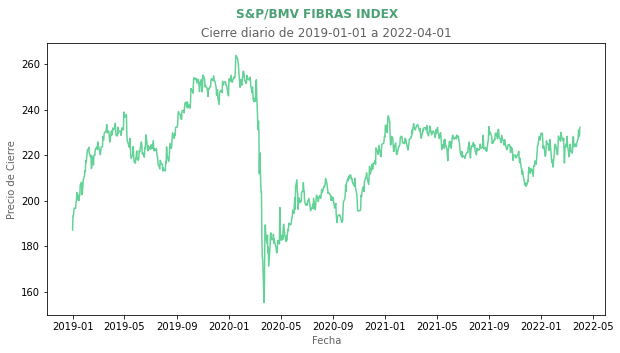

In [111]:
# Grafica de Precio de Cierre
plt.figure(figsize=(10,5))
plt.plot(sp_fibras_indx.index, sp_fibras_indx["Price Close"], c=color_subtitulo)
plt.suptitle("S&P/BMV FIBRAS INDEX", c=color_titulo, weight="bold")
plt.title("Cierre diario de {} a {}".format(start_date, end_date), c=color_cuerpo)
plt.xlabel("Fecha", c=color_cuerpo)
plt.ylabel("Precio de Cierre", c=color_cuerpo)

Text(0, 0.5, 'Rendimiento diario')

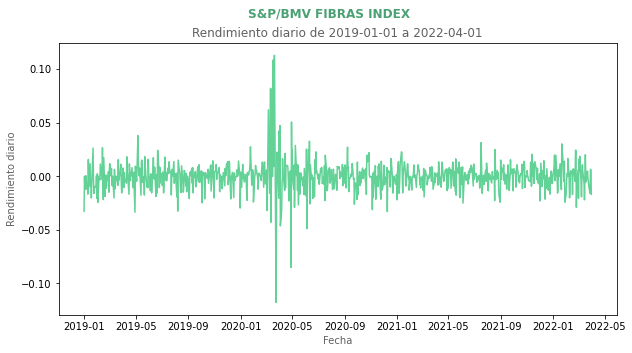

In [112]:
# Grafica de rendimientos diarios
plt.figure(figsize=(10,5))
plt.plot(sp_fibras_indx.index, sp_fibras_indx["Close Returns"], c=color_subtitulo)
plt.suptitle("S&P/BMV FIBRAS INDEX", c=color_titulo, weight="bold")
plt.title("Rendimiento diario de {} a {}".format(start_date, end_date), c=color_cuerpo)
plt.xlabel("Fecha", c=color_cuerpo)
plt.ylabel("Rendimiento diario", c=color_cuerpo)

#### FIBRAs seleccionadas

In [148]:
# Subdataframe de FIBRAs seleccionadas
instrumentos_fibras = instrumentos_df[instrumentos_df["Subcategoría"] == "FIBRA"]
# Haz una lista con las FIBRAs
fibras = instrumentos_fibras.index.to_list()
# Obten informacion de las FIBRAs
fibras_info = rd.get_data(
    universe=fibras,
    fields=fields_acciones
    ).set_index("Instrument")
# Cambia y traduce el nombre de las oclumnas
fibras_info.columns = ["Descripción", "País de intercambio"]
# Presenta los resultados
fibras_info["Benchmark"] = "S&P/BMV FIBRAS INDEX TR"
fibras_info["Benchmark RIC"] = ".FR"

,Descripción,País de intercambio
Instrument,,
EDUCA18.MX,Grupo Nagoin SA de CV,Mexico
FMTY14.MX,Fibra Mty SAPI de CV,Mexico
DANHOS13.MX,Concentradora Fibra Danhos SA de CV,Mexico
FNOVA17.MX,Proyectos Inmobiliarios Carne Mart SA de CV,Mexico


In [129]:
# Total returns de FIBRAs
fibras_tr = (rd.get_history(
    universe=fibras,
    fields="TR.TotalReturn", # Cambios en el precio + Dividendos
    interval="daily", # Resultados diarios
    start=start_date,
    end=end_date)
    .sort_index(ascending=True) # Regresa los resultados con fecha ascendente
    .droplevel(1, axis="columns") # Quita el nivel de subcolumna "Total Return"
    .astype("str")
    .replace({"<NA>":np.nan})
    .astype("float64")
    .fillna(method="pad") # Rellena los valores vacios con el último valor observado
    .drop_duplicates() # Elimina los duplicados
    .loc[start_date:end_date] # Localiza solo los registros para las fechas establecidas
    )
# Presenta los resultados
fibras_tr

,EDUCA18.MX,FMTY14.MX,DANHOS13.MX,FNOVA17.MX
Date,,,,
2019-01-02 00:00:00+00:00,0.000000,0.000000,2.410676,0.000000
2019-01-03 00:00:00+00:00,-1.050000,0.083822,0.210172,0.000000
2019-01-04 00:00:00+00:00,-1.050000,-0.753769,-0.041946,0.000000
2019-01-07 00:00:00+00:00,-0.960081,0.000000,0.671423,0.000000
2019-01-08 00:00:00+00:00,2.040816,0.000000,1.959150,0.000000
...,...,...,...,...
2022-03-28 00:00:00+00:00,-3.130946,-1.748808,0.041425,-0.138360
2022-03-29 00:00:00+00:00,0.000000,-0.566343,3.146998,0.103914
2022-03-30 00:00:00+00:00,0.000000,-0.081367,-2.047371,0.000000


In [184]:
x = instrumentos_fibras.join(fibras_info)

In [185]:
y = instrumentos_etfs_econInd.join(etfs_econInd_info[["Descripción","País de intercambio", "Benchmark", "Benchmark RIC"]])

In [190]:
pd.concat([x,y])

,Tipo,Categoría,Subcategoría,Benchmark,Benchmark RIC,Descripción,País de intercambio
EDUCA18.MX,Renta Variable,Acción,FIBRA,S&P/BMV FIBRAS INDEX TR,.FR,Grupo Nagoin SA de CV,Mexico
FMTY14.MX,Renta Variable,Acción,FIBRA,S&P/BMV FIBRAS INDEX TR,.FR,Fibra Mty SAPI de CV,Mexico
DANHOS13.MX,Renta Variable,Acción,FIBRA,S&P/BMV FIBRAS INDEX TR,.FR,Concentradora Fibra Danhos SA de CV,Mexico
FNOVA17.MX,Renta Variable,Acción,FIBRA,S&P/BMV FIBRAS INDEX TR,.FR,Proyectos Inmobiliarios Carne Mart SA de CV,Mexico
IVV,Renta Variable,ETF,Economía Indexada,S&P 500 TR,.SPXTR,iShares Core S&P 500 ETF,Estados Unidos de América
MCHI.O,Renta Variable,ETF,Economía Indexada,MSCI China NR USD,.dMICN00000NUS,iShares MSCI China ETF,Estados Unidos de América
EWJ,Renta Variable,ETF,Economía Indexada,MSCI Japan NR USD,.dMIJP00000NUS,iShares MSCI Japan ETF,Estados Unidos de América
EWU,Renta Variable,ETF,Economía Indexada,MSCI United Kingdom NR USD,.dMIGB00000NUS,iShares MSCI United Kingdom ETF,Estados Unidos de América
NAFTRACISHRS.MX,Renta Variable,ETF,Economía Indexada,S&P/BMV IPC,.MXX,iShares NAFTRAC,México
